In [2]:
%matplotlib inline

import pyarrow.parquet as pq
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

In [3]:
df = pq.read_table('PDFMalware2022.parquet').to_pandas()
df = df.drop(columns="Header")

In [4]:
df.head()

,FileName,PdfSize,MetadataSize,Pages,XrefLength,TitleCharacters,isEncrypted,EmbeddedFiles,Images,Text,...,AA,OpenAction,Acroform,JBIG2Decode,RichMedia,Launch,EmbeddedFile,XFA,Colors,Class
0,aedaf3c5428a2e3ba600c44b96ad78dfdf8ed76e7df129...,8.0,180.0,1.0,11.0,0.0,0.0,0.0,0,No,...,0,1,0,0,0,0,0,0,0.0,Malicious
1,fe767fb2584a10c010626263ea950643ac25f6ca24628f...,15.0,224.0,0.0,20.0,7.0,0.0,0.0,0,No,...,0,0,1,0,0,0,8,1,0.0,Malicious
2,544c5223ee301affad514b6fa585b3191625aba0a7222b...,4.0,468.0,2.0,13.0,16.0,0.0,0.0,0,Yes,...,0,1,0,0,0,0,0,0,0.0,Malicious
3,669772e626deccb9cfb7eb6a61e13d248d0ea08f1abe15...,17.0,250.0,1.0,15.0,0.0,0.0,0.0,0,No,...,0,1,1,0,0,0,0,0,0.0,Malicious
4,e434c884f45a691b0bf33d765f61794007eb0b8bb9f590...,7.0,252.0,3.0,16.0,45.0,0.0,0.0,0,Yes,...,0,1,0,0,0,0,0,0,0.0,Malicious


In [5]:
df['Class'].value_counts()

Class
Malicious    5555
Benign       4468
Name: count, dtype: int64

In [6]:
df.set_index('FileName', inplace=True)

In [7]:
from pyreal.transformers import Transformer, OneHotEncoder, MultiTypeImputer, fit_transformers, run_transformers

cat_cols = ["Text", "Header", "Class"]
cols_to_fix = df.select_dtypes(exclude='number').columns
cols_to_fix = [col for col in cols_to_fix if col not in cat_cols]

for col in cols_to_fix:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df['Text'] = df['Text'].apply(lambda x: 1 if x == 'Yes' else 0 if x == 'No' else None)
    
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='Class'), df['Class'], test_size=0.2, random_state=42)

imputer = MultiTypeImputer()
#ohe = OneHotEncoder(columns=cat_cols)
#text_fixer = Transformer.from_transform_function(clean_text_column)
transformers = [imputer]

X_train = fit_transformers(transformers, X_train)
X_test = run_transformers(transformers, X_test)

In [13]:
import pycaret.classification as pc

df_train = X_train.copy()
df_train['Class'] = y_train

exp = pc.ClassificationExperiment()

exp.setup(data=df_train, target='Class')
exp.models()
best = exp.compare_models(sort='AUC', include=["rf", "dt"])

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:04:35
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/13 [00:00<?, ?it/s]

In [14]:
best

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=1617, verbose=0,
                       warm_start=False)

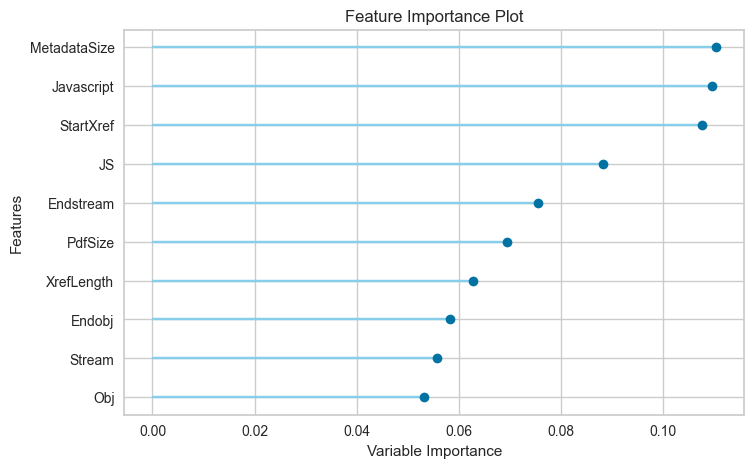

In [15]:
exp.plot_model(best, plot="feature")

<Axes: >

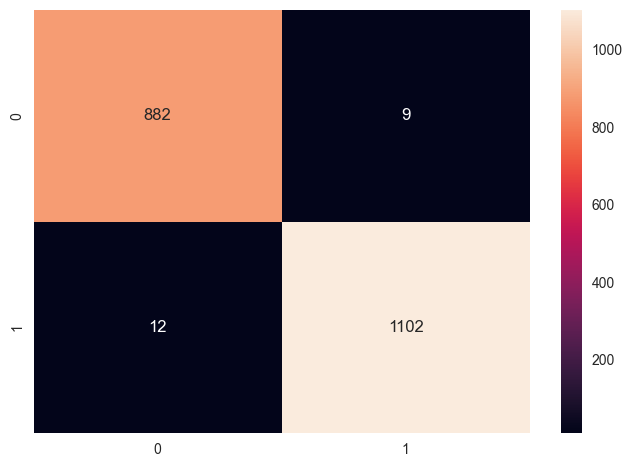

In [17]:
preds = exp.predict_model(best, data=X_test, raw_score=True)["prediction_label"]

# plot a confusion matrix of preds vs y_test
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, fmt='d')

<Axes: >

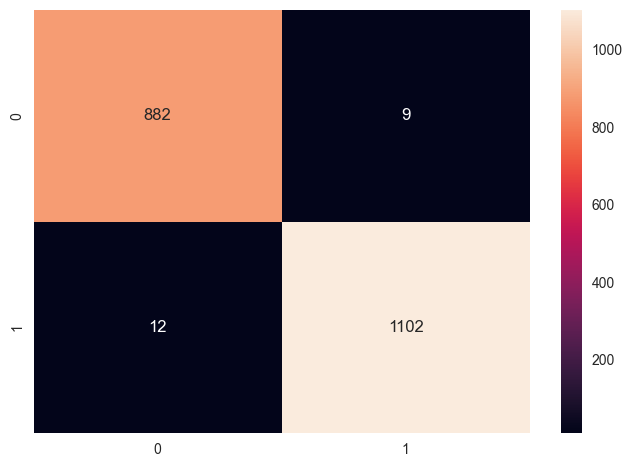

In [18]:
preds = best.predict(X_test)
# convert t_test from ["Benign", "Malware"] to [0, 1]
y_test = y_test.apply(lambda x: 0 if x == "Benign" else 1)
cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, fmt='d')

In [19]:
exp.get_config('pipeline')

Pipeline(memory=FastMemory(location=C:\Users\Ola\AppData\Local\Temp\joblib),
         steps=[('label_encoding',
                 TransformerWrapperWithInverse(exclude=None, include=None,
                                               transformer=LabelEncoder())),
                ('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['PdfSize', 'MetadataSize', 'Pages',
                                             'XrefLength', 'TitleCharacters',
                                             'isEncrypted', 'EmbeddedFiles',
                                             'Images'...
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='mean'))),
                ('categorical_imputer',
                 TransformerWrapper(exclude=None, include=[],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='most_frequent')))],
         verbose=False)

In [20]:
feature_descriptions = {
    "PdfSize": "Total size",
    "MetadataSize": "Size of metadata",
    "Pages": "Number of pages",
    "XrefLength": "Number of entries in Xref tables",
    "TitleCharacters": "Number of characters in the title",
    "isEncrypted": "Document encryption status",
    "EmbeddedFiles": "Number of embedded files",
    "Images": "Number of images",
    "Text": "Presence of text inside the PDF",
    "Header": "Presence of a valid PDF header",
    "Obj": "Number of total objects inside the PDF",
    "Endobj": "Number of endobj keywords",
    "Stream": "Number of streams in the PDF",
    "Endstream": "Number of endstreams keywords",
    "Xref": "Number of Xref tables",
    "Trailer": "Number of trailers inside the PDF",
    "StartXref": "Number of startxref keywords",
    "PageNo": "Number of pages",
    "Encrypt": "Document encryption status",
    "ObjStm": "Number of stream objects (ObjStm)",
    "JS": "Number of Javascript keywords",
    "Javascript": "Number of Javascript keywords",
    "AA": "Number of AA keywords",
    "OpenAction": "Number of OpenAction keywords",
    "Acroform": "Number of Acroform tags",
    "JBIG2Decode": "Presence of JBig2Decode filter",
    "RichMedia": "Number of RichMedia keywords",
    "Launch": "Number of Launch keywords",
    "EmbeddedFile": "Number of embedded files",
    "XFA": "Number of XFA tags",
    "Colors": "Number of unique colors used",
}

In [ ]:
from pyreal import RealApp

app = RealApp(best, transformers=transformers, X_train_orig=X_train, y_train=y_train.apply(lambda x: 0 if x == "Benign" else 1), feature_descriptions=feature_descriptions)

importances = app.produce_feature_importance()

 54%|===========         | 8659/16036 [06:35<05:36]       

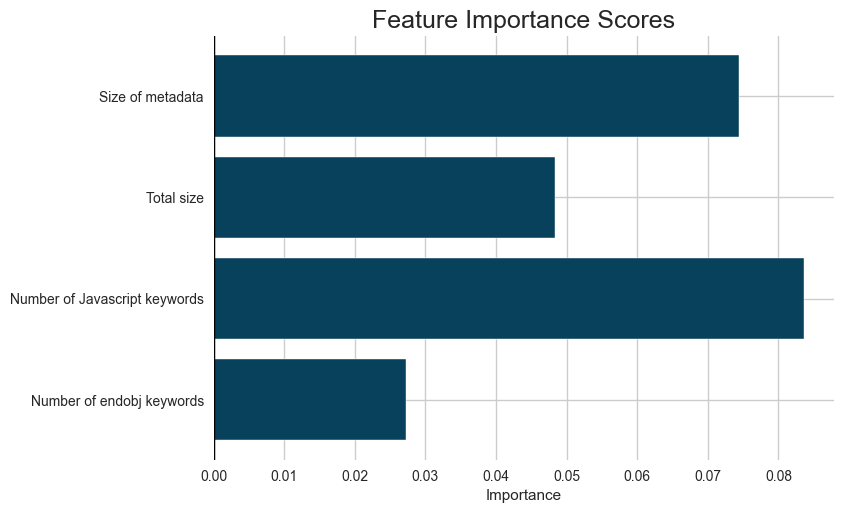

In [23]:
from pyreal.visualize import feature_bar_plot

feature_bar_plot(importances)